# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

In [3]:
numbers = mnist.load_data()[0][0]

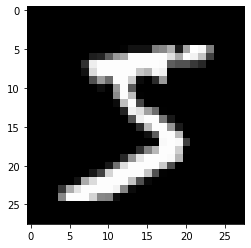

In [4]:
img = numbers[0]
plt.imshow(img, cmap="gray");

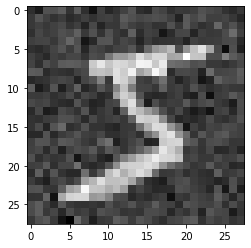

In [5]:
noisy = img + np.random.normal(scale=32, size=img.shape)
plt.imshow(noisy, cmap="gray");

In [6]:
img = plt.imread("boat.png")
print(img.shape)
img = img[:,:,0]
print(img.shape)

(512, 512, 4)
(512, 512)


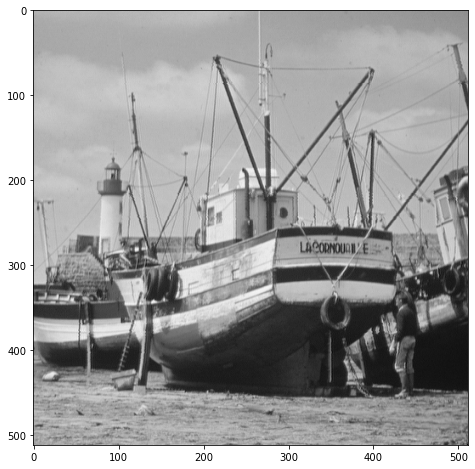

In [7]:
plt.figure(figsize=(15,8))
plt.imshow(img, cmap="gray");

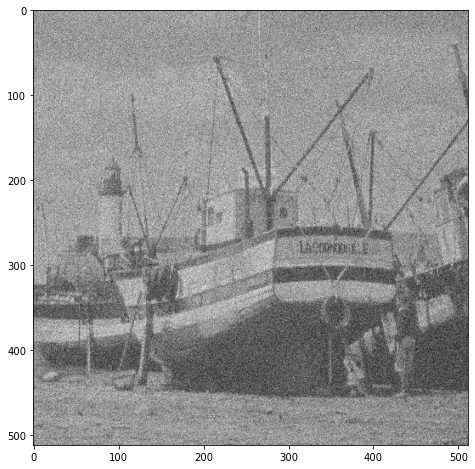

In [8]:
noisy = img + np.random.normal(scale=0.15, size=img.shape)
plt.figure(figsize=(15,8))
plt.imshow(noisy, cmap="gray");

# Paramètres

In [9]:
T2D = lambda x: x
T3D_ht = lambda x: x
T3D_ht_inv = lambda x: x
T3D_wie = lambda x: x
T3D_wie_inv = lambda x: x

N = 128
step = 32
neighborhood = step*2 

threshold_t2d_ht = 0.01
threshold_dist_set = 15
threshold_t3d_ht = 0.01

sigma_ht = 1
sigma_wie = 1

# Fonctions

In [10]:
def generate_block(img, x, N=N):
    
    ret = np.zeros((N,N))
    
    x_min = max(0, x[0])
    y_min = max(0, x[1])

    x_max = min(x[0]+N, img.shape[0])
    y_max = min(x[1]+N, img.shape[1])

    ret[x_min-x[0]:x_max-x[0], y_min-x[1]:y_max-x[1]] = img[x_min:x_max, y_min:y_max]
    
    return ret

In [11]:
def dist(img1, img2, transfo_2D, threshold=None, N=N):
    
    T1 = transfo_2D(img1).copy()
    T2 = transfo_2D(img2).copy()
    
    if not threshold == None:
        T1[T1 < threshold] = 0
        T2[T2 < threshold] = 0

    return np.linalg.norm(T1 - T2)**2 / N**2

In [ ]:
def calculate_dist(x, block_ref, img, dist_func, T2D=T2D, threshold_dist=threshold_t2d_ht, N=N):
    
    block = generate_block(img, x, N)
    
    return dist_func(block_ref, block, T2D, threshold=threshold_dist)

In [12]:
def create_set(xR, img, dist_func, T2D=T2D, threshold_dist=threshold_t2d_ht, thresh_dist_set=threshold_dist_set, nmax=None, neighborhood=neighborhood, N=N):

    xs = []
    dists = []
    
    x_min = max(xR[0]-neighborhood, -N+1)
    y_min = max(xR[1]-neighborhood, -N+1)
    
    x_max = min(xR[0]+neighborhood, img.shape[0])
    y_max = min(xR[1]+neighborhood, img.shape[0])

    block_ref = generate_block(img, xR)

    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            
            x = np.array([i, j])
            block = generate_block(img, x, N)
            
            dist = dist_func(block_ref, block, T2D, threshold=threshold_dist)
            
            if dist < thresh_dist_set:
                xs.append(x)
                dists.append(dist)
                
    set_xR = []
    
    if nmax == None:
        nmax = len(dists)
    
    for i in np.argsort(dists)[:nmax]:
        set_xR.append(xs[i])
        
    return set_xR

In [13]:
def stack(ens, img):
    
    ret = [generate_block(img, x) for x in ens]
    ret = np.stack(ret, axis=2)
    
    return ret

In [14]:
def transform_3D_ht(Z, w, threshold=threshold_t3d_ht, T3D=T3D_ht, T3D_inv=T3D_ht_inv):
    
    # For symmetry with transform_3D_wie
    w = None
    
    T = T3D(Z).copy()
    T[T < threshold] = 0
    
    return T3D_inv(T)

In [15]:
def generate_weights_ht(xRs, noisy, nmax_set=None, sigma=sigma_ht):
    
    weights = []
    sets = []
    
    print(" - ", end="")
    
    for i, xR in enumerate(xRs):
        
        S = create_set(xR, noisy, dist, nmax=nmax_set)
        Z = stack(S, noisy)
        sets.append(S)
        
        Y_hat = transform_3D_ht(Z, None)
        nz = np.count_nonzero(Y_hat)
        
        if nz == 0:
            weights.append(1)
        else:
            weights.append(1/(sigma**2 * nz))
            
        print(f" - Génération des sets ht : {i+1} / {len(xRs)}", end='\r')
            
    print("")
            
    return weights, sets

In [16]:
def aggregation(xRs, img, weights, sets, transform_3D, N=N):
    
    height, width = img.shape
    
    num = np.zeros_like(img)
    den = np.zeros_like(img)
    
    current_pixel = 1
    
    print(" - ", end="")
    
    for w, xR, S in zip(weights, xRs, sets):
        
        Y_hat = transform_3D(stack(S, img), w)
        
        #print(xR, len(S))
        
        for i in range(xR[0], min(xR[0]+N, height)):
            for j in range(xR[1], min(xR[1]+N, width)):
                
                num[i,j] += Y_hat[i-xR[0],j-xR[1],:].sum() * w
                
                for x in S:
                    if (i >= x[0] and i < x[0]+N) and (j >= x[1] and j < x[1]+N):
                        den[i,j] += w
        
        print(f" - Aggrégation : {current_pixel} / {len(xRs)}", end='\r')
        
        current_pixel += 1
                        
    print("")
    
    return num, den

In [17]:
def recreate_basic(xRs, noisy, nmax_set=None):
    
    weights, sets = generate_weights_ht(xRs, noisy, nmax_set=nmax_set)
    
    num, den = aggregation(xRs, noisy, weights, sets, transform_3D_ht)
    
    den[den==0] = 1
    y = num/den
    
    y = y.clip(max=y.max()/2)
    y = y / np.max(y) * np.median(noisy)
    
    return y

In [18]:
def generate_w_wie(xRs, basic, noisy, nmax_set=None, T3D=T3D_wie, sigma=sigma_wie):
    
    Ws = []
    sets = []
    
    print(" - ", end="")
    
    for i, xR in enumerate(xRs):
        
        S = create_set(xR, basic, dist, threshold_dist=None, nmax=nmax_set)
        Y = stack(S, basic)
        sets.append(S)
        
        T = T3D(Y)**2
        W = T**2 / (T**2 + sigma**2)
        
        Ws.append(W)
        
        print(f" - Génération des sets wie : {i+1} / {len(xRs)}", end='\r')
        
    print("")
            
    return Ws, sets

In [19]:
def transform_3D_wie(Z, W, T3D=T3D_wie, T3D_inv=T3D_wie_inv):
    
    collaborative_filtering = np.multiply(W, T3D(Z))
    
    return T3D_inv(collaborative_filtering)

In [20]:
def recreate_final(xRs, basic, noisy, nmax_set=None, sigma=sigma_wie):
    
    Ws, sets = generate_w_wie(xRs, basic, noisy, nmax_set=nmax_set, sigma=sigma)
    weights = [1 / (np.linalg.norm(W)**2 * sigma**2) for W in Ws]
    
    num, den = aggregation(xRs, noisy, weights, sets, transform_3D_wie)
    
    den[den==0] = 1
    y = num/den
    
    y = y.clip(max=y.max()/2)
    y = y / np.max(y) * np.median(noisy)
    
    return y

In [21]:
def algo(xRs, noisy, nmax_set=None):
    
    basic = recreate_basic(xRs, noisy, nmax_set)
    final = recreate_final(xRs, basic, noisy, nmax_set)
    
    return final

# Tests

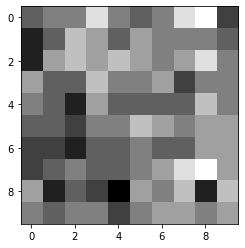

In [22]:
xR = np.array([12, 12])
block = generate_block(img, xR, 10)
plt.imshow(block, cmap="gray");

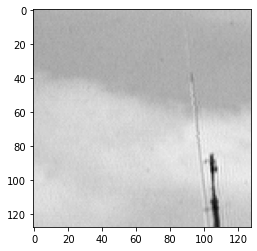

In [23]:
xR = np.array([12, 12])
block = generate_block(img, xR)
plt.imshow(block, cmap="gray");

0.002474802158544037


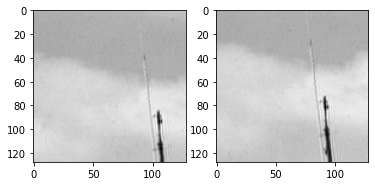

In [24]:
xR = np.array([12, 12])
x = np.array([24, 26])

block_ref = generate_block(img, xR)
block = generate_block(img, x)

print(dist(block_ref, block, T2D))

plt.subplot(1, 2, 1)
plt.imshow(block_ref, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(block, cmap="gray");

0.04626129041517553


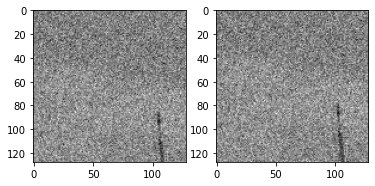

In [25]:
xR = np.array([12, 12])
x = np.array([19, 15])

block_ref = generate_block(noisy, xR)
block = generate_block(noisy, x)

print(dist(block_ref, block, T2D))

plt.subplot(1, 2, 1)
plt.imshow(block_ref, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(block, cmap="gray");

3


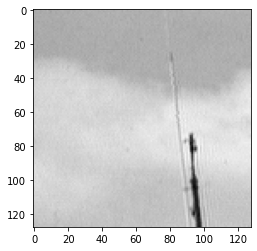

In [26]:
xR = np.array([24, 24])
S = create_set(xR, noisy, dist, threshold_dist=64, thresh_dist_set=100, nmax=3)

print(len(S))

block_ref = generate_block(img, xR)
plt.imshow(block_ref, cmap="gray");

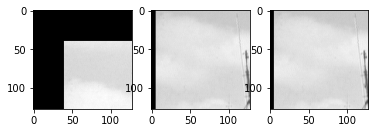

In [27]:
for i, x in enumerate(S):
    block = generate_block(img, x)
    plt.subplot(1, len(S), i+1)
    plt.imshow(block, cmap="gray")
plt.plot();

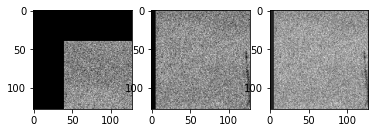

In [28]:
for i, x in enumerate(S):
    block = generate_block(noisy, x)
    plt.subplot(1, len(S), i+1)
    plt.imshow(block, cmap="gray")
plt.plot();

In [29]:
Z = stack(S, noisy)
print(Z.shape)

(128, 128, 3)


In [30]:
Y_hat = transform_3D_ht(Z, 32)
print(Y_hat.shape)

(128, 128, 3)


In [31]:
xR = np.array([12, 12])
weights, sets = generate_weights_ht([xR], noisy, nmax_set=10)

 - Génération des sets ht : 1 / 1


In [32]:
weights, sets

([6.1042607740202665e-06],
 [[array([12, 12]),
   array([14, 12]),
   array([14, 13]),
   array([11, 12]),
   array([13, 12]),
   array([10, 11]),
   array([10, 12]),
   array([ 8, 13]),
   array([18, 12]),
   array([16, 11])]])

In [33]:
num, den = aggregation([xR], noisy, weights, sets, transform_3D_ht)

 - Aggrégation : 1 / 1


In [34]:
xR = np.array([12, 12])
new_image = recreate_basic([xR], noisy, nmax_set=10)

 - Génération des sets ht : 1 / 1
 - Aggrégation : 1 / 1


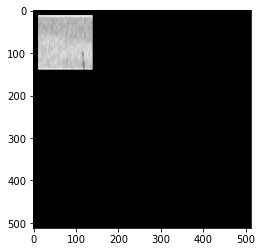

In [35]:
plt.imshow(new_image, cmap="gray");

In [36]:
xRs = [np.array([i, j]) for i in range(0, img.shape[0], step) for j in range(0, img.shape[1], step)]

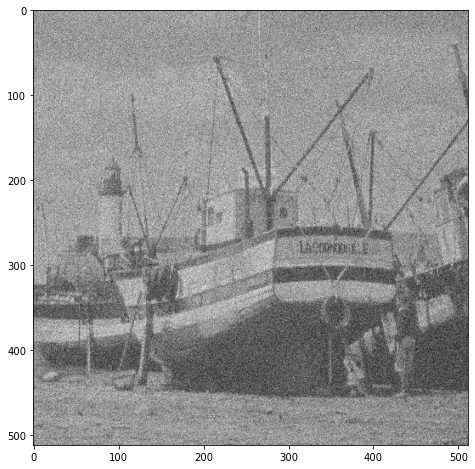

In [37]:
plt.figure(figsize=(15,8))
plt.imshow(noisy, cmap="gray");

In [87]:
new_image = recreate_basic(xRs, noisy, nmax_set=5)
plt.figure(figsize=(15,8))
plt.imshow(new_image, cmap="gray");

KeyboardInterrupt: 

0.02142533895642223


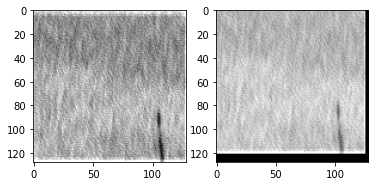

In [38]:
xR = np.array([12, 12])
x = np.array([19, 15])

block_ref = generate_block(new_image, xR)
block = generate_block(new_image, x)

print(dist(block_ref, block, lambda x: x))

plt.subplot(1, 2, 1)
plt.imshow(block_ref, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(block, cmap="gray");

In [39]:
xR = np.array([12, 12])
generate_w_wie([xR], new_image, noisy, nmax_set=1)

 - Génération des sets wie : 1 / 1


([array([[[0.09728284],
          [0.09728284],
          [0.09728284],
          ...,
          [0.09728284],
          [0.09728284],
          [0.09728284]],
  
         [[0.09728284],
          [0.09728284],
          [0.09728284],
          ...,
          [0.09728284],
          [0.09728284],
          [0.09728284]],
  
         [[0.09728284],
          [0.05058851],
          [0.05004865],
          ...,
          [0.09547256],
          [0.09488494],
          [0.09728284]],
  
         ...,
  
         [[0.09728284],
          [0.06597798],
          [0.07930858],
          ...,
          [0.05886636],
          [0.04387224],
          [0.09728284]],
  
         [[0.09728284],
          [0.09728284],
          [0.09728284],
          ...,
          [0.09728284],
          [0.09728284],
          [0.09728284]],
  
         [[0.09728284],
          [0.09728284],
          [0.09728284],
          ...,
          [0.09728284],
          [0.09728284],
          [0.09728284]]])],
 [[ar

In [40]:
xR = np.array([12, 12])
basic_image = recreate_basic([xR], noisy, nmax_set=5)

 - Génération des sets ht : 1 / 1
 - Aggrégation : 1 / 1


In [41]:
final_image = recreate_final([xR], basic_image, noisy, nmax_set=5)

 - Génération des sets wie : 1 / 1
 - Aggrégation : 1 / 1


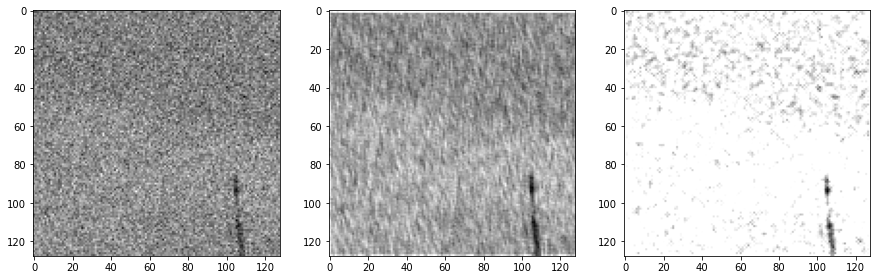

In [42]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(generate_block(noisy, xR), cmap="gray")

plt.subplot(1,3,2)
plt.imshow(generate_block(basic_image, xR), cmap="gray")

plt.subplot(1,3,3)
plt.imshow(generate_block(final_image, xR), cmap="gray")

plt.plot();

In [43]:
xRs = [np.array([i, j]) for i in range(-N+1, img.shape[0], step) for j in range(-N+1, img.shape[1], step)]

In [44]:
basic = recreate_basic(xRs, noisy)

KeyboardInterrupt: 

In [39]:
final = recreate_final(xRs, basic, noisy)

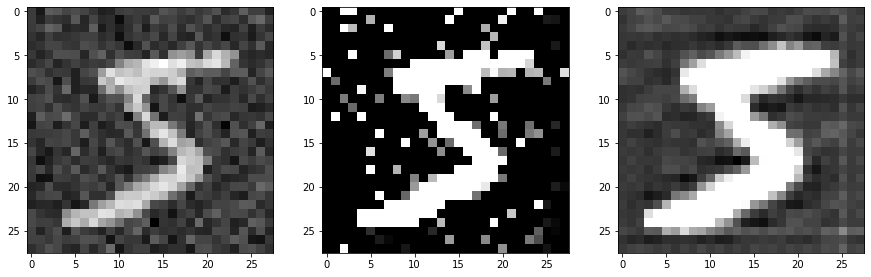

In [40]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(noisy, cmap="gray")

plt.subplot(1,3,2)
plt.imshow(basic, cmap="gray")

plt.subplot(1,3,3)
plt.imshow(final, cmap="gray")

plt.plot();

# Algo final

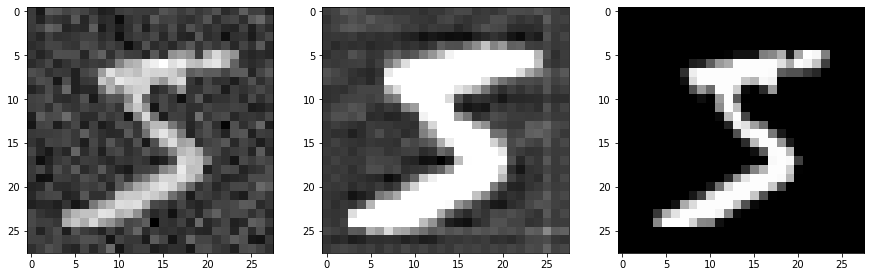

In [41]:
y = algo(xRs, noisy)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(noisy, cmap="gray")

plt.subplot(1,3,2)
plt.imshow(y, cmap="gray")

plt.subplot(1,3,3)
plt.imshow(img, cmap="gray")

plt.plot();